# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [ ]:
batchsize = 64
inputShape = (32,32,1)

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,40000)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,20000)

Let us look at some input-output pairs

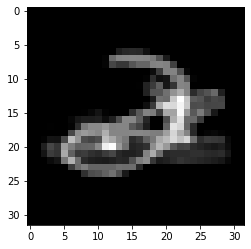

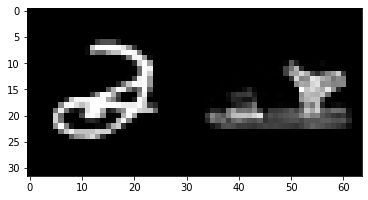

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as ks
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

from keras.utils.layer_utils import count_params

In [ ]:
def plot_images(imgs, titles, n_images = 8, figsize=(10,10)):
    imgs_per_rows = 1
    cols = len(imgs)
    if cols <= 2:
        imgs_per_rows = 4 // cols
    
    imgs = [img[:n_images].clip(0,1).astype('float64') for img in imgs]
    
    plt.figure(figsize=figsize)
    for i in range(n_images):
        for j in range(cols):
            ax = plt.subplot(n_images // imgs_per_rows, imgs_per_rows * cols, cols*i + j+1)
            plt.imshow(imgs[j][i], cmap='gray', interpolation='nearest')
            plt.title(titles[j])
            plt.axis("off")

def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x, cmap='gray', interpolation='nearest')
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y, cmap='gray', interpolation='nearest')
    if title:
        plt.title(title[1])

    plt.show()

In [ ]:
def mse(y, y_pred):
    m = ks.metrics.MeanSquaredError()
    m.update_state(y, y_pred)
    return m.result().numpy()

def compute_metrics(original, noisy, metrics):
    results = {}
    for name, metric in metrics.items():
        results[name] = metric(original, noisy)
    return results

def plot_history(history, metric='loss'):
    training = history.history[metric]
    val = history.history[f'val_{metric}']

    # Loss
    plt.plot(training)
    plt.plot(val)
    plt.grid()
    plt.title(f'{metric.capitalize()} during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

metric = 'mse'
        
metrics = {'MSE': mse}

# Unbalanced Parallel U-Nets


The first idea that came to my mind once i read the purpose of the project was to adapt a U-Net to separate the images instead of segmentate the input. After a while I realized that parallelizing the task using one U-Net for the first dataset and another one for the second one was a good idea. Initially I started using exactly the same U-Net for both mnist and fashion mnist but after some observations I understood that fashion mnist needed an extra push. So I decided to unbalance the nets assigning more channels to the one working with the fashion mnist half of the image.

Output layer Remarks: To use the U-Net for this purpose it is necessary to modify the output layer(s) since the sigmoid activation function wouldn't make sense in this case.
Furthermore the output of the net is composed by three layers:

*   y1: MNIST U-NET's output
*   y2: FASHION MNIST U-NET's output
*    y: Concatenation of y1 and y2

y1 and y2 could have not been outputted but I decided to keep them to better monitor the performances of the net on the single datasets. As a matter of fact this led to the already mentioned decision to unbalance the U-Nets.

Loss function remark: MAE seemed to work better than MSE. Besides the usage of MAE for image restoring is advised by literature.

In [ ]:
def build_punet(input_shape, n_ch1=48, n_ch2=64, L=4, conv_per_L=3):
    
    x = ks.layers.Input(shape=input_shape)

    # DOWN
    backup_layers1 = []
    backup_layers2 = []
    h1 = x
    h2 = x
    for l in range(L):

        for c in range(conv_per_L):
            h1 = ks.layers.Conv2D(n_ch1, 3, 1, padding='same')(h1)
            h1 = ks.layers.ReLU()(h1)

            h2 = ks.layers.Conv2D(n_ch2, 3, 1, padding='same')(h2)
            h2 = ks.layers.ReLU()(h2)

        if l < L-1:
            # Downsample
            backup_layers1.append(h1)
            backup_layers2.append(h2)

            h1 = ks.layers.MaxPool2D(padding='same')(h1)
            h2 = ks.layers.MaxPool2D(padding='same')(h2)

            n_ch1 = n_ch1 * 2
            n_ch2 = n_ch2 * 2
    
    # UP
    for l in range(L-1):
        n_ch1 = n_ch1 // 2
        n_ch2 = n_ch2 // 2

        # Upsample
        h1 = ks.layers.Conv2DTranspose(n_ch1, 3, 2, padding='same')(h1)
        h2 = ks.layers.Conv2DTranspose(n_ch2, 3, 2, padding='same')(h2)

        # Concatenate
        h1 = ks.layers.concatenate([h1, backup_layers1.pop(-1)])
        h2 = ks.layers.concatenate([h2, backup_layers2.pop(-1)])

        for c in range(conv_per_L):
            h1 = ks.layers.Conv2D(n_ch1, 3, 1, padding='same')(h1)
            h1 = ks.layers.ReLU()(h1)
            h2 = ks.layers.Conv2D(n_ch2, 3, 1, padding='same')(h2)
            h2 = ks.layers.ReLU()(h2)
        
    # Output
    y1 = ks.layers.Conv2D(1, 1, name='y1')(h1)
    y2 = ks.layers.Conv2D(1, 1, name='y2')(h2)
    y = ks.layers.concatenate([y1,y2], axis=2, name='y')

    return ks.models.Model(x, [y1, y2, y])

model = build_punet(inputShape)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 48)   480         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 48)   0           ['conv2d[0][0]']                 
                                                                                              

# Data generator exploitation

Given the very large amount of possible combinations ($60000^2$), the model can be trained changing the training set (thus also the validation set) every 10 epochs permitting the model to be able to generalize very well avoiding overfitting. This approach is time consuming and could be reiterated many times to achieve slight improvements.

I personally don't like this kind of approach given the small marginal gain on mse with respect to the very large amount of time needed.
**However**, this approach achieves the best score and **has to be considered the best one** for this project.

# Training

Different callbacks were used: 

*   ReduceLROnPlateau which reduces the learning rate when the loss is not improving
*   ModelCheckpoint and BackupAndRestore which allowed me to automatically save the best weights and pause/resume the training respectively



In [ ]:
working_dir = 'unet'
loss = 'mae'
lr = 1e-3
epochs = 10
batch_size = 32
monitor = f'val_y_{metric}'

reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')

# ModelCheckpoint
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

# Backup and restore 
backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

callbacks = [
    reduce_on_plateau_callback,
    backup_callback,
    model_checkpoint_callback,
]

optimizer = ks.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
x, y = next(train_generator)
history = model.fit(x, [y[:,:,:32],y[:,:,32:], y],
                        batch_size=batch_size,
                        validation_split=0.1,
                        epochs= epochs,
                        shuffle = True,
                        callbacks=callbacks)

Epoch 1/10
1125/1125 [==============================] - 83s 74ms/step - loss: 0.0107 - y1_loss: 0.0034 - y2_loss: 0.0037 - y_loss: 0.0036 - y1_mse: 4.0564e-04 - y2_mse: 4.7967e-04 - y_mse: 4.4265e-04 - val_loss: 0.0105 - val_y1_loss: 0.0033 - val_y2_loss: 0.0036 - val_y_loss: 0.0035 - val_y1_mse: 3.9284e-04 - val_y2_mse: 4.6330e-04 - val_y_mse: 4.2807e-04 - lr: 1.2500e-04
Epoch 2/10
1125/1125 [==============================] - 83s 74ms/step - loss: 0.0106 - y1_loss: 0.0034 - y2_loss: 0.0037 - y_loss: 0.0035 - y1_mse: 3.8766e-04 - y2_mse: 4.6716e-04 - y_mse: 4.2741e-04 - val_loss: 0.0105 - val_y1_loss: 0.0033 - val_y2_loss: 0.0037 - val_y_loss: 0.0035 - val_y1_mse: 3.9067e-04 - val_y2_mse: 4.5850e-04 - val_y_mse: 4.2459e-04 - lr: 1.2500e-04
Epoch 3/10
1125/1125 [==============================] - 83s 74ms/step - loss: 0.0105 - y1_loss: 0.0033 - y2_loss: 0.0037 - y_loss: 0.0035 - y1_mse: 3.7726e-04 - y2_mse: 4.5691e-04 - y_mse: 4.1708e-04 - val_loss: 0.0104 - val_y1_loss: 0.0033 - val_y2_

# Training results

Hereafter only the last 10 training epochs are shown due to the adopted approach

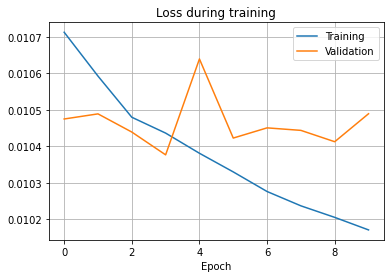

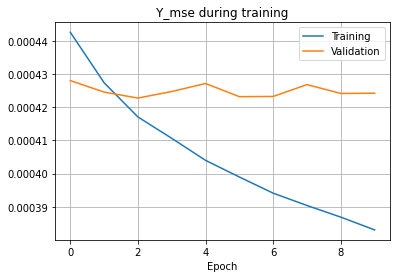

In [ ]:
plot_history(history, 'loss')
plot_history(history, 'y_mse')

# Model evaluation

The model was evaluated 10 times on a 20000 samples test set.
The mean and standard deviation of the evaluation are reported.

In [ ]:
def evaluate_model(model, x, y, metrics):
    _, _, y_pred = model.predict(x) 
   
    results = compute_metrics(y, y_pred, metrics)

    return results

eval = np.empty(0)
for i in range(10):
  x_test, y_test = next(test_generator)
  ev = evaluate_model(model, x_test,  y_test, {'MSE': mse}).get('MSE')
  eval = np.append(eval,ev)

print(eval)

mean = np.mean(eval)
std = np.std(eval)
print('Mean: ',mean)
print('Standard deviation: ',std)

[0.00045776 0.00045279 0.00044525 0.00045988 0.0004452  0.0004542
 0.0004505  0.00044415 0.0004533  0.00045144]
Mean:  0.000451446499209851
Standard deviation:  5.052357847847523e-06


The results are also visually excellent and small differences can be barely noticed.

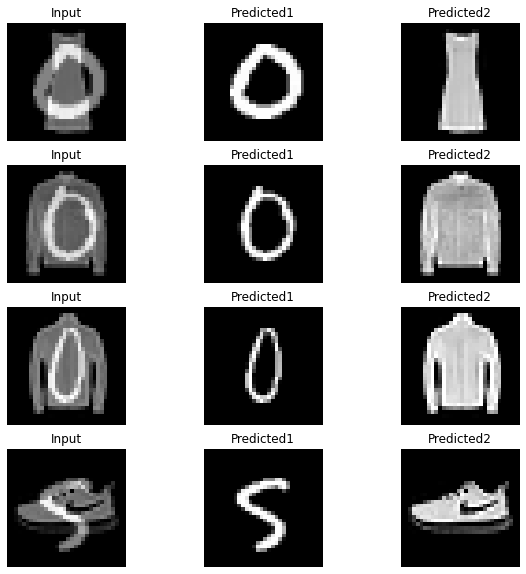

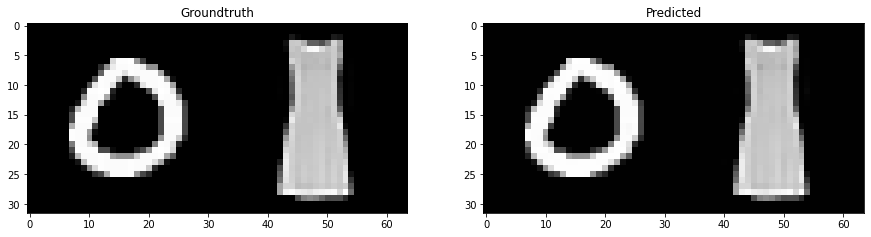

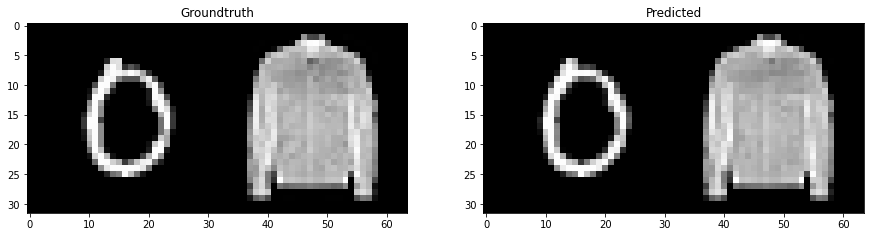

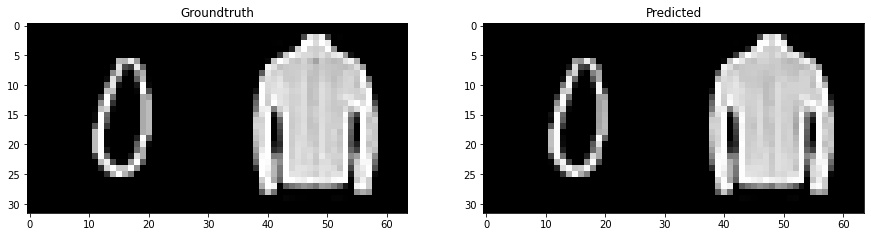

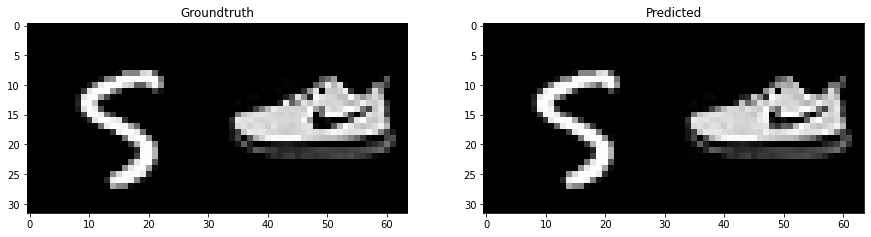

In [ ]:
n_images = 4
y_pred1, y_pred2, y_pred = model.predict(x[:n_images])
y_pred1 = y_pred1.squeeze()
y_pred2 = y_pred2.squeeze()
y_pred = y_pred.squeeze()

plot_images([x, y_pred1, y_pred2], ['Input', 'Predicted1', 'Predicted2'], n_images)

for i in range(n_images):
  show(y[i], y_pred[i], title=['Groundtruth','Predicted'])

# One shot

The second approach consists in using the exact same model trained using a big "fixed" generated set. In this case the model is trained for less than 100 epochs but takes several time for each one of them. The hyperparameters are left untouched in order to compare the results.

**WARNING:** this approach utilizes lots of RAM, thus Colab Pro and extended RAM setting is suggested to run it safely.

In [ ]:
train_generator_one_shot = datagenerator(mnist_x_train,fashion_mnist_x_train,250000)
x_o, y_o = next(train_generator_one_shot)

In [ ]:
model2 = build_punet(inputShape)

# Training

In this case, along with the already mentioned callbacks, early stopping was utilized to avoid overfitting.

In [ ]:
working_dir = 'unet_oneshot'
loss = 'mae'
lr = 1e-3
epochs = 100
batch_size = 32
monitor = f'val_y_{metric}'

early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=15, verbose=1, mode='auto', restore_best_weights=True)
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')

# ModelCheckpoint
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

# Backup and restore
backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callback,
    backup_callback,
    model_checkpoint_callback,
]

optimizer = ks.optimizers.Adam(learning_rate=lr)
model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history_o = model2.fit(x_o, [y_o[:,:,:32],y_o[:,:,32:],y_o],
                    batch_size=batch_size,
                    validation_split=0.1,
                    epochs= epochs,
                    shuffle = True,
                    callbacks=callbacks)

Epoch 1/100
7032/7032 [==============================] - 556s 77ms/step - loss: 0.0347 - y1_loss: 0.0091 - y2_loss: 0.0140 - y_loss: 0.0116 - y1_mse: 0.0020 - y2_mse: 0.0025 - y_mse: 0.0023 - val_loss: 0.0229 - val_y1_loss: 0.0067 - val_y2_loss: 0.0086 - val_y_loss: 0.0076 - val_y1_mse: 0.0010 - val_y2_mse: 9.9359e-04 - val_y_mse: 0.0010 - lr: 0.0010
Epoch 2/100
7032/7032 [==============================] - 535s 76ms/step - loss: 0.0207 - y1_loss: 0.0060 - y2_loss: 0.0078 - y_loss: 0.0069 - y1_mse: 8.9987e-04 - y2_mse: 8.9594e-04 - y_mse: 8.9790e-04 - val_loss: 0.0179 - val_y1_loss: 0.0055 - val_y2_loss: 0.0065 - val_y_loss: 0.0060 - val_y1_mse: 8.0981e-04 - val_y2_mse: 8.3821e-04 - val_y_mse: 8.2401e-04 - lr: 0.0010
Epoch 3/100
7032/7032 [==============================] - 532s 76ms/step - loss: 0.0187 - y1_loss: 0.0055 - y2_loss: 0.0070 - y_loss: 0.0062 - y1_mse: 7.8106e-04 - y2_mse: 7.7044e-04 - y_mse: 7.7575e-04 - val_loss: 0.0188 - val_y1_loss: 0.0054 - val_y2_loss: 0.0071 - val_y_l

# Training results

The model improves very slightly from epoch 23 to epoch 37 which gave the best score. The model starts overfitting around epoch 40.

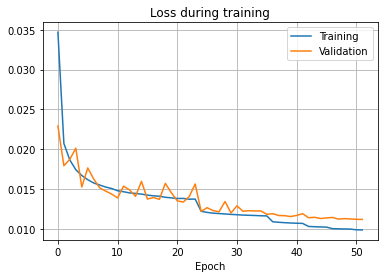

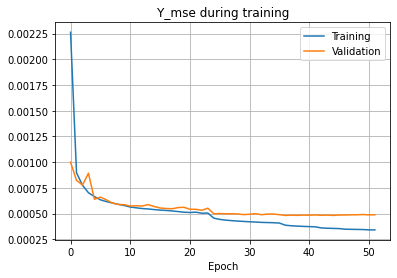

In [ ]:
plot_history(history_o, 'loss')
plot_history(history_o, 'y_mse')

# Model evaluation

In [ ]:
x_test, y_test = next(test_generator)

In [ ]:
eval = np.empty(0)
for i in range(10):
  x_test, y_test = next(test_generator)
  ev = evaluate_model(model2, x_test,  y_test, {'MSE': mse}).get('MSE')
  eval = np.append(eval,ev)

print(eval)

mean = np.mean(eval)
std = np.std(eval)
print('Mean: ',mean)
print('Standard deviation: ',std)

[0.00049018 0.0004917  0.00049148 0.00048409 0.00049045 0.00049558
 0.00049839 0.00049276 0.00048718 0.0004958 ]
Mean:  0.0004917606216622517
Standard deviation:  4.000268155261511e-06


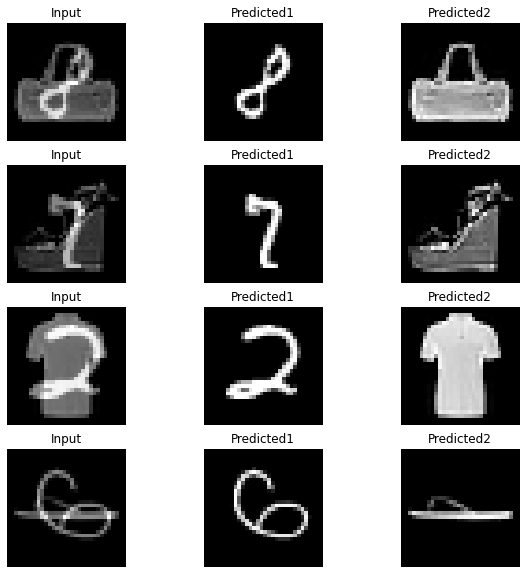

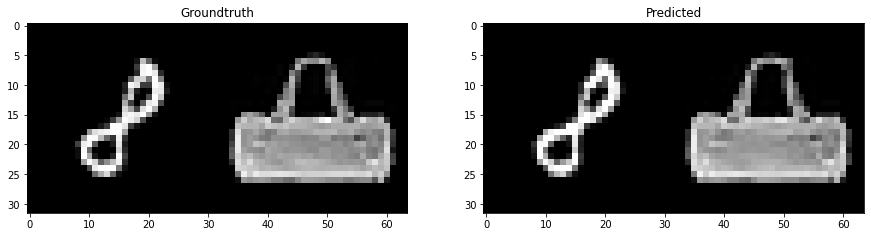

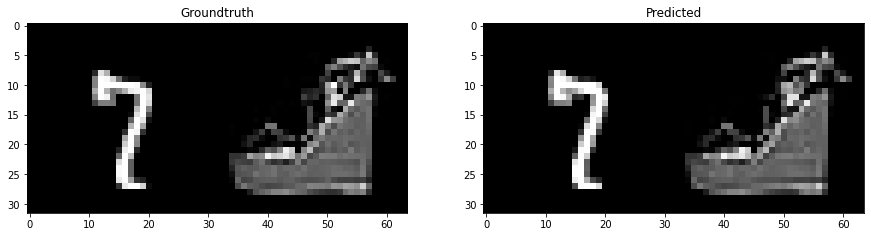

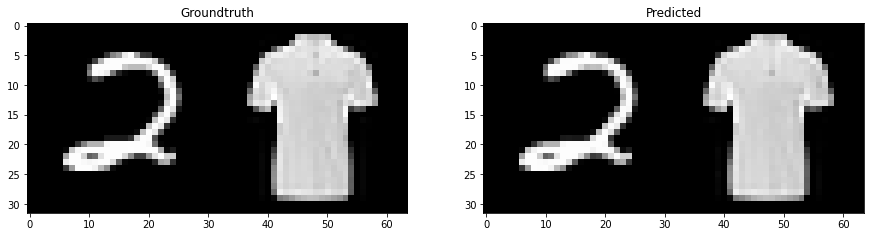

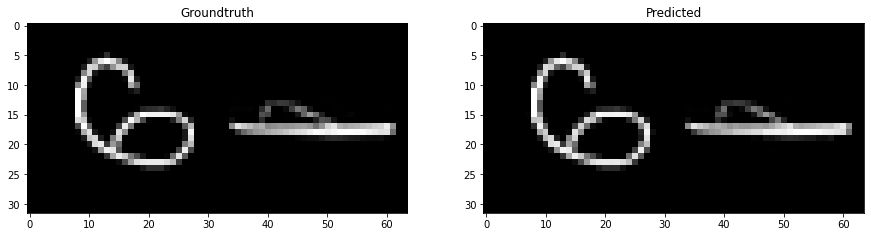

In [ ]:
n_images = 4
y_pred1, y_pred2, y_pred = model2.predict(x_o[:n_images])
y_pred1 = y_pred1.squeeze()
y_pred2 = y_pred2.squeeze()
y_pred = y_pred.squeeze()
plot_images([x_o, y_pred1, y_pred2], ['Input', 'Predicted1', 'Predicted2'], n_images)

for i in range(n_images):
  show(y_o[i], y_pred[i], title=['Groundtruth','Predicted'])


The visual results are very good since little differences can be barely seen. Even though the mse is lower using this approach, the order of magnitude on which the comparison is made is very little.

# Conclusions

The best approach is the first one exploiting the data generator.